In [ ]:
%pip install nfl_data_py
%pip install fuzzywuzzy
%pip install python-Levenshtein
%pip install networkx
%pip install wordcloud
%pip install seaborn
%pip install mplcursors
%pip install altair vega_datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nfl_data_py as nfl
import altair as alt

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
from wordcloud import WordCloud

from fuzzywuzzy import process
from matplotlib.ticker import FuncFormatter

In [ ]:
# Load play-by-play data for 2024 season
df = nfl.import_pbp_data([2024])

# Load seasonal rosters for 2024 season
roster_data = nfl.import_seasonal_rosters([2024])

# Load weekly rosters for 2024 season
weekly_rosters = nfl.import_weekly_rosters([2024])

# Show first 5 rows
print(df.head())
print(roster_data.head())

2024 done.
Downcasting floats.
   play_id          game_id old_game_id home_team away_team season_type  week  \
0      1.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
1     40.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
2     61.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
3     83.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
4    108.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   

  posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0    None         None    None  ...           0.0                   0.0   
1     ARI         away     BUF  ...           0.0                   0.0   
2     ARI         away     BUF  ...           0.0                   0.0   
3     ARI         away     BUF  ...           0.0                   0.0   
4     ARI         away     BUF  ...           0.0                   0.0   

     qb_epa  xyac_epa  xyac_mea

In [ ]:
pbp_column_list = df.columns.tolist()
print(pbp_column_list)

roster_column_list = roster_data.columns.tolist()
print(roster_column_list)

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

# Merging the data

We will be merging salary data from overthecap.com with our nfl roster_data based on fuzzy matching the player names from both data sources.

In [ ]:
# Fuzzy match helper function
def get_best_match(player, choices, threshold=85):
    match, score = process.extractOne(player, choices)
    return match if score >= threshold else None


In [ ]:

df_salary = pd.read_csv('overthecap/overthecap-earnings.csv')
df_salary = df_salary[df_salary['year'] == 2024]

team_map = {
    'Vikings': 'MIN',
    'Packers': 'GB',
    'Bears': 'CHI',
    'Lions': 'DET',
    'Texans': 'HOU',
    'Titans': 'TEN',
    'Colts': 'IND',
    'Jaguars': 'JAX',
    'Ravens': 'BAL',
    'Steelers': 'PIT',
    'Bengals': 'CIN',
    'Browns': 'CLE',
    'Cowboys': 'DAL',
    'Giants': 'NYG',
    'Eagles': 'PHI',
    'Commanders': 'WAS',
    'Falcons': 'ATL',
    'Panthers': 'CAR',
    'Saints': 'NO',
    'Buccaneers': 'TB',
    'Cardinals': 'ARI',
    'Rams': 'LAR',
    '49ers': 'SF',
    'Seahawks': 'SEA',
    'Bills': 'BUF',
    'Dolphins': 'MIA',
    'Patriots': 'NE',
    'Jets': 'NYJ',
    'Chargers': 'LAC',
    'Raiders': 'LV',
    'Chiefs': 'KC',
    'Broncos': 'DEN',
    'Panthers': 'CAR',
}

df_salary['identifier'] = df_salary['player_name'] + '-' + df_salary['team'].map(team_map)

df_salary

,player_name,year,team,base_salary,prorated_bonus,roster_bonus,workout_bonus,Unnamed: 7,guaranteed_salary,capnumber,cap_percent,cash_paid,identifier
0,Andrew DePaola,2024,Vikings,1210000,116666.0,0.0,15000.0,NaN,0.0,1341666,0.5%,1225000,Andrew DePaola-MIN
1,Zach Wood,2024,Saints,1210000,200000.0,NaN,NaN,NaN,130000.0,1410000,0.5%,1210000,Zach Wood-NO
2,Jon Weeks,2024,Texans,1210000,167500.0,NaN,0.0,NaN,0.0,1152500,0.4%,1377500,Jon Weeks-HOU
3,James Winchester,2024,Chiefs,1210000,167500.0,NaN,0.0,NaN,985000.0,1152500,0.5%,1377500,James Winchester-KC
4,Rick Lovato,2024,Eagles,1210000,50000.0,NaN,0.0,NaN,50000.0,1035000,0.4%,1260000,Rick Lovato-PHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,Casey Kreiter,2024,Giants,1210000,167500.0,NaN,0.0,NaN,985000.0,1152500,0.4%,1377500,Casey Kreiter-NYG
2577,Trent Sieg,2024,Cowboys,1125000,167500.0,0.0,NaN,NaN,985000.0,1152500,0.4%,1292500,Trent Sieg-DAL
2578,Patrick Scales,2024,Bears,1210000,167500.0,NaN,NaN,NaN,985000.0,1152500,0.4%,1377500,Patrick Scales-CHI
2579,Tyler Ott,2024,Commanders,1210000,133333.0,NaN,75000.0,NaN,1210000.0,1418333,0.5%,1685000,Tyler Ott-WAS


In [168]:
# Create identifier, handling NaN values in team column
roster_data['team'] = roster_data['team'].dropna()
roster_data['identifier'] = roster_data['player_name'] + '-' + roster_data['team']

identifiers = df_salary['identifier'].unique().tolist()

# Fuzzy match each player
roster_data['matched_identifier'] = roster_data['identifier'].apply(
    lambda x: get_best_match(x, identifiers)
)

# Merge on matched identifiers (not matched_salary_name)
player_salary_df = pd.merge(
    roster_data,
    df_salary,
    left_on='matched_identifier',
    right_on='identifier',
    how='left'
)

# Drop players with no salary info
player_salary_df = player_salary_df.dropna(subset=['base_salary'])


# Cleaning the Play-by-Play Data

We only take the data where the first down is successful, i.e. where the first_down columns equals 1.

In [ ]:
#now we take only data where first down is successful, success first down is 1
#other options are n/a or 0 we don't need either of these for analysis

# Filter for plays where a first down was achieved
first_down_plays = df[df['first_down'] == 1]

total_plays = len(df)

# Total number of first downs
total_first_downs = len(first_down_plays)

print("Total plays:", total_plays)
print("Total first downs:", int(total_first_downs))

Total plays: 49492
Total first downs: 11148


# How much does each team pay for their first downs?

Now we will examine first down conversions by team. We will again,  To do this we will use the "posteam" column that indicates the team that had possession of the ball (i.e. the team on offense). We will also see how much each team pays for its active offense players.

In [142]:
# First, find how many first downs each team has achieved

# Group by team on offense and count first downs
first_downs_by_team = first_down_plays.groupby('posteam')['first_down'].count()

first_downs_by_team = first_downs_by_team.sort_values(ascending=False)

# Sort and display
print(first_downs_by_team.sort_values(ascending=False).head())

posteam
WAS    447
PHI    440
BAL    438
DET    433
BUF    423
Name: first_down, dtype: int64


In [155]:
# Now we will get the active offensive players from the weekly rosters
active_roster_data = weekly_rosters[weekly_rosters['status'] == 'ACT']

offensive_positions = [
    'QB', 'RB', 'WR', 'TE', 'OL'
]

# Filter roster data for offensive positions
active_offensive_players = active_roster_data[
    active_roster_data['position'].isin(offensive_positions)
]

# Get only unique player names
active_offensive_players = active_offensive_players[['player_name', 'team', 'position', 'player_id']].drop_duplicates()

active_offensive_players

# Merge active offensive players with salary data
active_offensive_players = pd.merge(
    active_offensive_players,
    player_salary_df[['player_name_x', 'base_salary', 'player_id']],
    on= 'player_id',
    how='left'
)

active_offensive_players = active_offensive_players.dropna(subset=['base_salary'])

# We may be using this dataframe later, so let's keep this for later use
active_offensive_players

,player_name,team,position,player_id,player_name_x,base_salary
0,Aaron Rodgers,NYJ,QB,00-0023459,Aaron Rodgers,3161112.0
1,Marcedes Lewis,CHI,TE,00-0024243,Marcedes Lewis,1600000.0
2,Joe Flacco,IND,QB,00-0026158,Joe Flacco,3000000.0
3,Josh Johnson,BAL,QB,00-0026300,Josh Johnson,1210000.0
4,Matthew Stafford,LA,QB,00-0026498,Matthew Stafford,23500000.0
...,...,...,...,...,...,...
1062,Rome Odunze,CHI,WR,00-0039919,Rome Odunze,795000.0
1063,Malachi Corley,NYJ,WR,00-0039920,Malachi Corley,795000.0
1064,Trey Benson,ARI,RB,00-0039921,Trey Benson,795000.0
1065,Amarius Mims,CIN,OL,00-0039925,Amarius Mims,795000.0


In [156]:
# Then we will get the total base salaries for each team
team_list = active_offensive_players['team'].unique().tolist()

team_total_salaries = []

for team in team_list:
    team_data = active_offensive_players[active_offensive_players['team'] == team]
    total_salary = team_data['base_salary'].sum()
    team_total_salaries.append({
        'team': team,
        'total_salary': total_salary
    })

team_salary_df = pd.DataFrame(team_total_salaries).sort_values(by='total_salary', ascending=False)

team_salary_df.head()

,team,total_salary
4,LA,96573859.0
2,IND,91935448.0
16,KC,79814507.0
8,ARI,75890199.0
30,CIN,73335782.0


In [157]:
# Join first downs by team with total salaries
team_first_downs = first_downs_by_team.reset_index().copy()
team_first_downs.columns = ['team', 'first_downs']
team_first_downs_with_salary = pd.merge(
    team_first_downs,
    team_salary_df,
    on='team',
    how='left'
)

team_first_downs_with_salary = team_first_downs_with_salary.sort_values(by='first_downs', ascending=False)

team_first_downs_with_salary.head()

,team,first_downs,total_salary
0,WAS,447,52659609.0
1,PHI,440,33236964.0
2,BAL,438,54210078.0
3,DET,433,40237410.0
4,BUF,423,30375680.0


In [158]:
average_team_salary = team_first_downs_with_salary['total_salary'].mean()
print(f"Average team salary: ${average_team_salary / 1_000_000:.3f} million")

Average team salary: $53.357 million


In [159]:
team_first_downs_with_salary['salary_per_first_down'] = team_first_downs_with_salary['total_salary'] / team_first_downs_with_salary['first_downs']
# Display the final DataFrame

team_first_downs_with_salary = team_first_downs_with_salary.sort_values(by='salary_per_first_down', ascending=True)

team_first_downs_with_salary.head()

,team,first_downs,total_salary,salary_per_first_down
4,BUF,423,30375680.0,71810.118203
1,PHI,440,33236964.0,75538.554545
3,DET,433,40237410.0,92927.043880
12,GB,354,34193592.0,96592.067797
13,SF,349,36838300.0,105553.868195


In [160]:
average_team_salary_per_first_down = team_first_downs_with_salary['salary_per_first_down'].mean()
print(f"Average team salary per first down: ${average_team_salary_per_first_down:.2f}")

Average team salary per first down: $156021.64


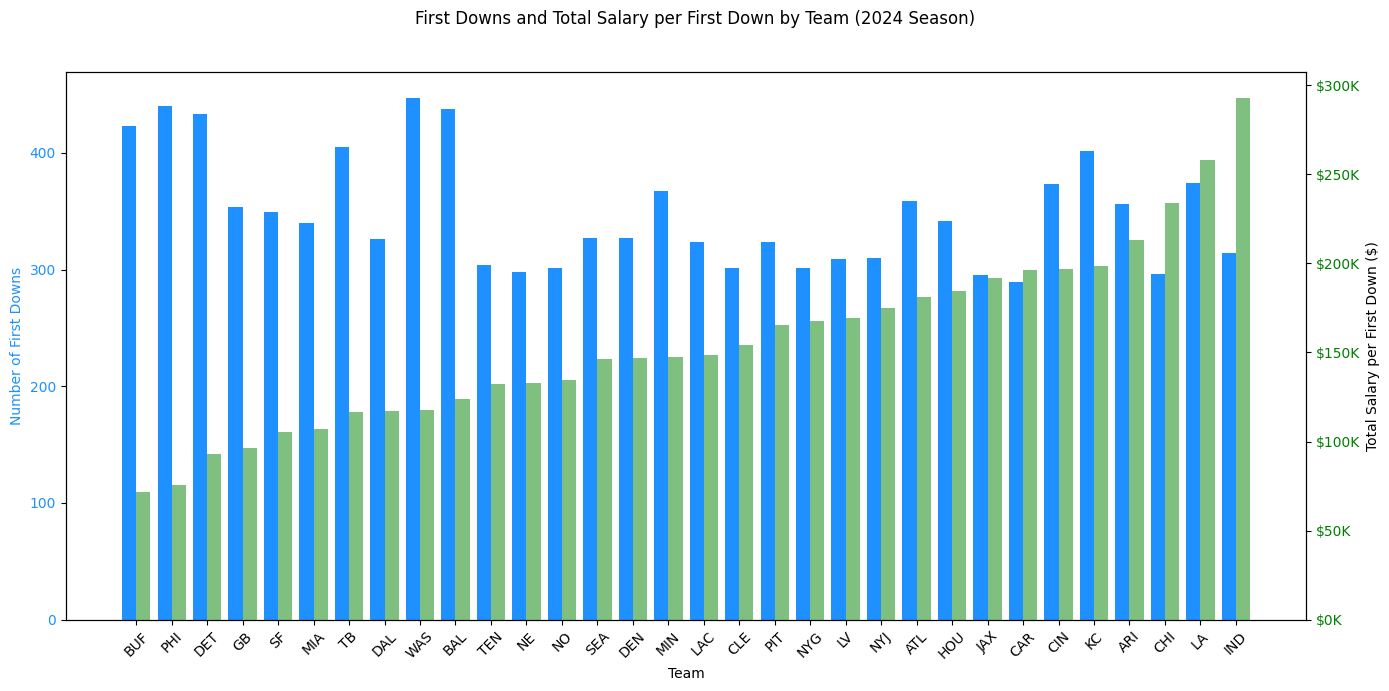

In [161]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Set bar width and positions
bar_width = 0.4
x = np.arange(len(team_first_downs_with_salary))

# Bars for first downs (left y-axis)
ax1.bar(x - bar_width/2, team_first_downs_with_salary['first_downs'], 
    width=bar_width, color='dodgerblue', label='First Downs')
ax1.set_xlabel('Team')
ax1.set_ylabel('Number of First Downs', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_xticks(x)
ax1.set_xticklabels(team_first_downs_with_salary['team'], rotation=45)

# Bars for total salary (right y-axis)
ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, team_first_downs_with_salary['salary_per_first_down'], 
    width=bar_width, color='green', alpha=0.5, label='Total Salary per First Down')
ax2.set_ylabel('Total Salary per First Down ($)',)
ax2.tick_params(axis='y', labelcolor='green')
formatter = FuncFormatter(lambda x, _: f'${x*1e-3:.0f}K')
ax2.yaxis.set_major_formatter(formatter)

ax2.tick_params(axis='y')

# Legends and title
fig.suptitle('First Downs and Total Salary per First Down by Team (2024 Season)')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The Buffalo Bills, Philadelphia Eagles, and the Detroit Lions pay the least total team salary per first down. 

The Indianapolis Colts, the LA Rams, and the Chicago Bears pay the most total salary per first down. 

In [162]:
total_salary = team_first_downs_with_salary['total_salary'].sum()

num_teams = len(team_first_downs_with_salary)

average_team_salary = total_salary / num_teams

average_salary_per_first_down = total_salary / total_first_downs if total_first_downs > 0 else 0

print(f"Total Salary for all teams: ${total_salary/1000_000:,.2f}M")
print(f"Average Total Salary per Team: ${average_team_salary/1000_000:,.2f}M")
print(f"Average Cost per First Down: ${average_salary_per_first_down:,.2f}")



Total Salary for all teams: $1,707.42M
Average Total Salary per Team: $53.36M
Average Cost per First Down: $153,159.34


# Visualizing where the most first down conversions occur and fail

We will now visualize where first downs occur on the field with a heat map. We will sort plays into bins representing a 5 yard section of the field. Bins with a darker hue indicate more first down conversions occurring in that section of the field. 

By multiplying each first down count by the average cost per first down, we can see how much each section of the field costs the league.

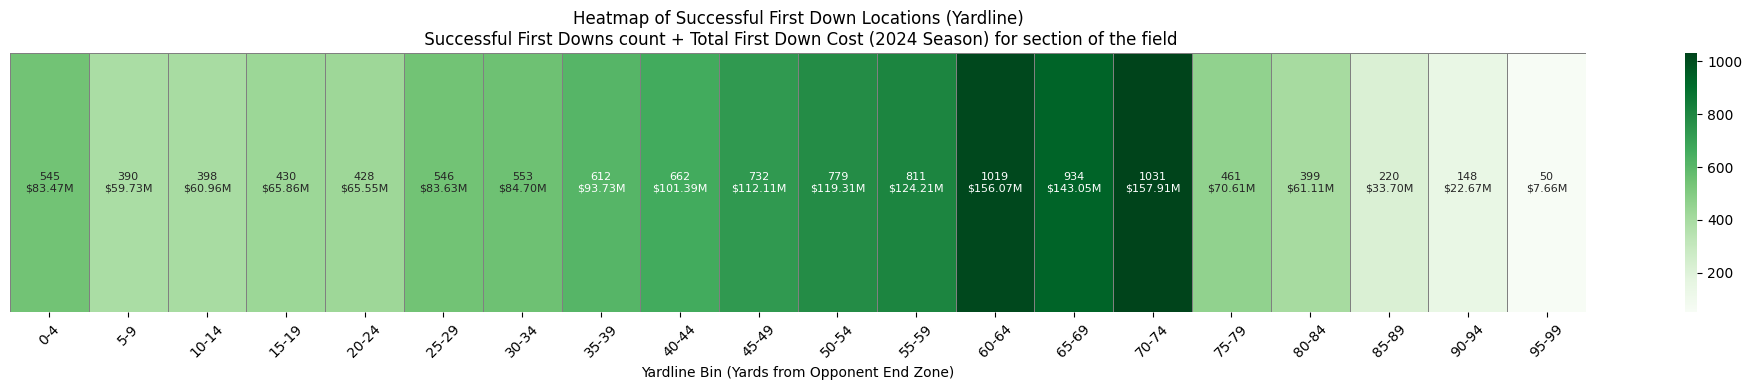

In [163]:
# Extract the yardline_100 and side_of_field (if exists) or just yardline_100
# yardline_100 is yards from opponent's end zone (0 to 100)
# For a heatmap, bin the yardline_100 into segments (for us here every 5 yards)
first_down_plays = first_down_plays.copy()

# Create bins for yardline_100, e.g., every 5 yards
first_down_plays['yard_bin'] = pd.cut(first_down_plays['yardline_100'], bins=range(0, 105, 5), right=False)

# Count first downs per bin
yard_counts = first_down_plays.groupby('yard_bin').size().reset_index(name='count')

# Total cost per first down for each yard bin
yard_counts['total_cost_per_first_down'] = (
    average_salary_per_first_down * yard_counts['count'].replace(0, np.nan)
)

# print(yard_counts['total_cost_per_first_down'].sum())

# Create annotations for the heatmap with average cost per first down
annotations = []
for i, row in yard_counts.iterrows():
    cost = row['total_cost_per_first_down']
    if pd.isna(cost):
        cost_str = "N/A"
    elif cost >= 1000000:
        cost_str = f"${cost/1000000:.2f}M"
    elif cost >= 1000:
        cost_str = f"${cost/1000:.0f}k"
    else:
        cost_str = f"${cost:.0f}"
    annotations.append(f"{row['count']}\n{cost_str}")

# Create the heatmap with custom annotations
plt.figure(figsize=(20, 4))
sns.heatmap([yard_counts['count']], cmap='Greens', cbar=True, linewidths=0.5, linecolor='gray', 
            annot=[annotations], fmt='', annot_kws={'fontsize': 8})

plt.title('Heatmap of Successful First Down Locations (Yardline)\n Successful First Downs count + Total First Down Cost (2024 Season) for section of the field')
plt.yticks([], [])  # Hide y-axis ticks since it's just one row
plt.xticks(ticks=[i + 0.5 for i in range(len(yard_counts))], labels=[f"{int(interval.left)}-{int(interval.right-1)}" for interval in yard_counts['yard_bin']], rotation=45)
plt.xlabel('Yardline Bin (Yards from Opponent End Zone)')

plt.tight_layout()
plt.show()

It looks like the most first down conversions happen at the 60-74 yardlines.

The least happen at both extremes. The lowest values are at 95-99 yards with low values are at 5-24 yards.

For the league as a whole, this shows that the most expensive areas are the 60-74 yard area. The least expensive areas are the 90-99 yard section of the field.

   yard_bin  count  count_successful  percentage_failed
0    [0, 5)    754               545          58.044650
1   [5, 10)    880               390          69.291339
2  [10, 15)    978               398          71.075581
3  [15, 20)    965               430          69.175627
4  [20, 25)   1090               428          71.805007


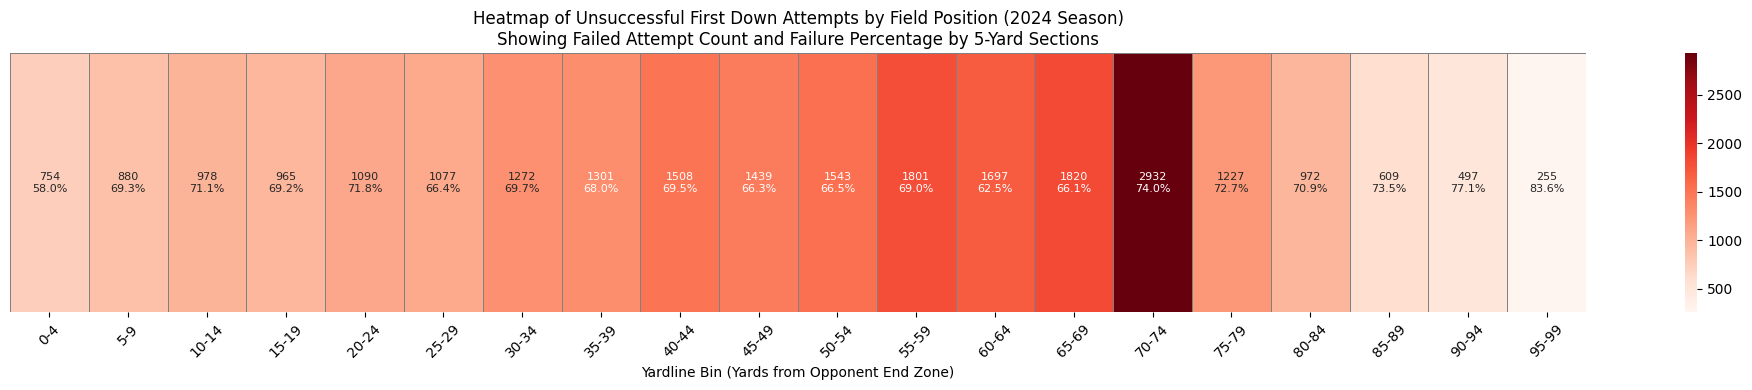

In [ ]:
pass_run_plays = df[df['play_type'].isin(['pass', 'run'])]

failed_first_down_plays = pass_run_plays[pass_run_plays['first_down'] != 1].copy()

# Create bins for yardline_100, e.g., every 5 yards
failed_first_down_plays['yard_bin'] = pd.cut(failed_first_down_plays['yardline_100'], bins=range(0, 105, 5), right=False)

# Count first downs per bin
failed_yard_counts = failed_first_down_plays.groupby('yard_bin').size().reset_index(name='count')

failed_yard_counts = failed_yard_counts.merge(yard_counts[['yard_bin', 'count']], on='yard_bin', how='left', suffixes=('', '_successful'))

failed_yard_counts['percentage_failed'] = (failed_yard_counts['count'] / (failed_yard_counts['count'] + failed_yard_counts['count_successful'])) * 100

print(failed_yard_counts.head())

# Create annotations for failed conversions with percentage
failed_annotations = []
for i, row in failed_yard_counts.iterrows():
    percentage = row['percentage_failed']
    if pd.isna(percentage):
        percentage_str = "N/A"
    else:
        percentage_str = f"{percentage:.1f}%"
    failed_annotations.append(f"{row['count']}\n{percentage_str}")

plt.figure(figsize=(20, 4))
sns.heatmap([failed_yard_counts['count']], cmap='Reds', cbar=True, linewidths=0.5, linecolor='gray', 
            annot=[failed_annotations], fmt='', annot_kws={'fontsize': 8})

plt.title('Heatmap of Unsuccessful First Down Attempts by Field Position (2024 Season)\nShowing Failed Attempt Count and Failure Percentage by 5-Yard Sections')
plt.yticks([], [])  # Hide y-axis ticks since it's just one row
plt.xticks(ticks=[i + 0.5 for i in range(len(failed_yard_counts))], labels=[f"{int(interval.left)}-{int(interval.right-1)}" for interval in failed_yard_counts['yard_bin']], rotation=45)
plt.xlabel('Yardline Bin (Yards from Opponent End Zone)')

plt.tight_layout()
plt.show()

The most first down failures happen at the 70-74 yard lines. Also the least first down failures happen at the 0-4 yard lines and 90-100 yard lines

First Down Efficiency seems relatively even across the whole board, with the rate of first down failures hovering between 60%-70%. There are outliers at the 90-100 and 0-4 yard range due to the low numbers.

This means the most plays happen at around the 70 yard line. The least number of plays happen at either extreme, at the 0-4 and 95-99 yard lines.

In [ ]:
def get_team_salaries(roster_data):
    """
    Get the total salaries for each team from the roster data.
    """
    # Filter out rows where salary is NaN
    roster_data = roster_data[roster_data['salary'].notna()]
    
    # Group by team and sum the salaries
    team_salaries = roster_data.groupby('team')['salary'].sum().reset_index()
    
    return team_salaries

# Player/Position Efficiency

We'll now see which players were in most first downs plays in 2024. There's no single column with all 22 players in a formation so we'll include players in strategic positions (such as quarterback, wide receiver, tight-end, running back) who have been named in the play by play data 

In [204]:
def get_player_info(player_id, column_name):
    """
    Get the player's name from the roster data using player_id.
    If player_id is not found, return 'Unknown Player'.
    """
    player_row = roster_data[roster_data['player_id'] == player_id]
    if not player_row.empty:
        return player_row[column_name].values[0]
    else:
        return 'Unknown Player'
    


# Define possible player columns for first down plays
possible_player_cols = [
    'passer_player_id',
    'rusher_player_id',
    'receiver_player_id'
]

# Make sure we only use existing columns
existing_player_cols = [col for col in possible_player_cols if col in first_down_plays.columns]

# Collect all player info using the id columns
player_info = []

for id_col in existing_player_cols:
    temp_df = first_down_plays[[id_col, 'posteam']].dropna()
    temp_df["player_name"] = temp_df[id_col].apply(lambda x: get_player_info(x, 'player_name'))
    temp_df["player_position"] = temp_df[id_col].apply(lambda x: get_player_info(x, 'position'))
    temp_df["player_id"] = temp_df[id_col]
    
    player_info.append(temp_df)

# Combine all information DataFrames into one DataFrame
all_player_info_df = pd.concat(player_info)

# Filter columns to only relevant columns: player name and team
all_player_teams = all_player_info_df[['player_name', 'posteam', 'player_id']]
all_player_teams.columns = ['Player', 'Team', 'player_id']

# # Count occurrences of each player-team pair
player_team_counts = all_player_teams.value_counts().reset_index()
player_team_counts.columns = ['Player', 'Team', 'player_id', 'First_Down_Count' ]

# Sort and show top results
player_team_counts = player_team_counts.sort_values(by='First_Down_Count', ascending=False).reset_index(drop=True)

# Show top 20
print(player_team_counts.head(20))

              Player Team   player_id  First_Down_Count
0     Jayden Daniels  WAS  00-0039910               281
1    Patrick Mahomes   KC  00-0033873               278
2      Lamar Jackson  BAL  00-0034796               277
3         Joe Burrow  CIN  00-0036442               270
4         Josh Allen  BUF  00-0034857               268
5         Jared Goff  DET  00-0033106               266
6     Baker Mayfield   TB  00-0034855               263
7        Jalen Hurts  PHI  00-0036389               257
8        Sam Darnold  MIN  00-0034869               248
9        C.J. Stroud  HOU  00-0039163               232
10        Geno Smith  SEA  00-0030565               228
11            Bo Nix  DEN  00-0039732               225
12      Kyler Murray  ARI  00-0035228               223
13       Brock Purdy   SF  00-0037834               214
14  Matthew Stafford   LA  00-0026498               213
15    Justin Herbert  LAC  00-0036355               208
16     Aaron Rodgers  NYJ  00-0023459           

We can visualize first down participations with a word cloud. Bigger names having contributed to more first downs

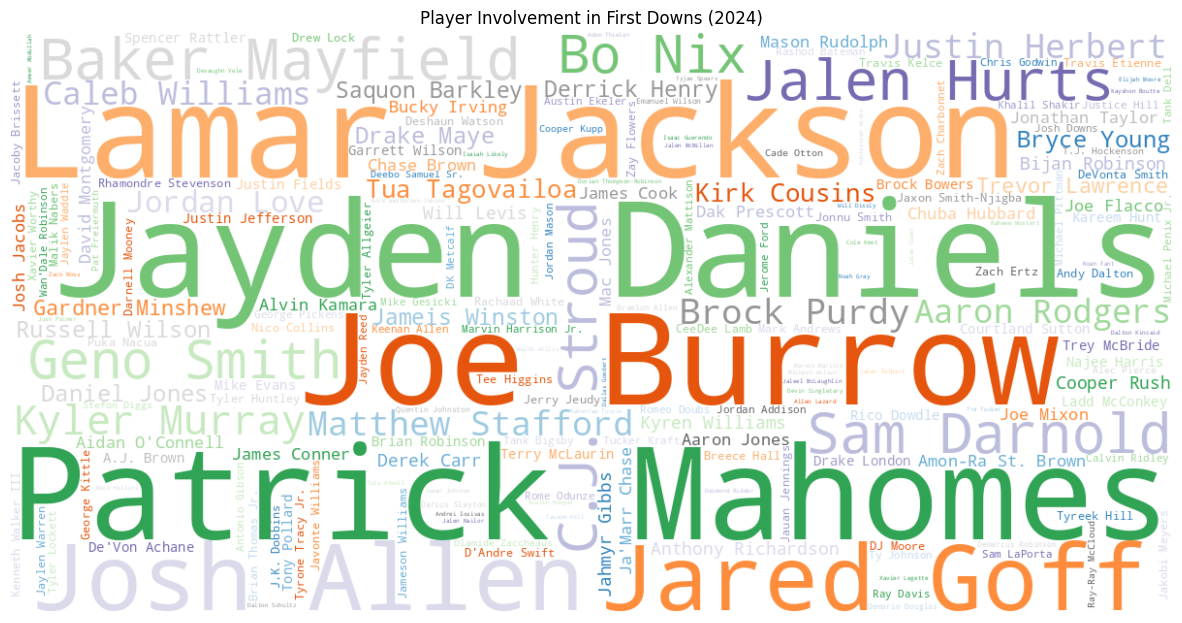

In [205]:
# Create the word cloud
player_counts = player_team_counts.set_index('Player')['First_Down_Count'].to_dict()

wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='tab20c').generate_from_frequencies(player_counts)

# Plot the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Player Involvement in First Downs (2024)')
plt.show()

Now that we know all the players we'll see which ones are most efficient cost-wise.

In [208]:
merged_df = pd.merge(
    player_team_counts,
    active_offensive_players[['player_name', 'team', 'base_salary', 'player_id']],
    left_on='player_id',
    right_on='player_id',
    how='left'
)
merged_df = merged_df.dropna(subset=['base_salary'])


With each player matched to their base salary, we can then sort them by their individual salary per first down they participated in.

In [209]:
# Convert base_salary to numeric, handling any potential issues with conversion
merged_df['base_salary'] = merged_df['base_salary'].astype(float)

print(merged_df.head())

# Compute salary per first down
merged_df['salary_per_first_down'] = merged_df['base_salary'] / merged_df['First_Down_Count']

# Clean final output
final_df = merged_df[['Player', 'team', 'First_Down_Count', 'base_salary', 'salary_per_first_down']]

# Remove duplicates: if player matched multiple teams, keep the one with most first downs
final_df = final_df.sort_values(['Player', 'First_Down_Count'], ascending=[True, False]).drop_duplicates('Player')

# Sort by salary efficiency
final_df = final_df.sort_values('salary_per_first_down', ascending=True)

# Format salary columns
final_df['base_salary'] = final_df['base_salary'].apply(lambda x: f"${x:,.2f}")
final_df['salary_per_first_down'] = final_df['salary_per_first_down'].apply(lambda x: f"${x:,.2f}")

# Display
print(final_df.head(20).to_string(index=False))

            Player Team   player_id  First_Down_Count      player_name team  \
0   Jayden Daniels  WAS  00-0039910               281   Jayden Daniels  WAS   
1  Patrick Mahomes   KC  00-0033873               278  Patrick Mahomes   KC   
2    Lamar Jackson  BAL  00-0034796               277    Lamar Jackson  BAL   
3       Joe Burrow  CIN  00-0036442               270       Joe Burrow  CIN   
4       Josh Allen  BUF  00-0034857               268       Josh Allen  BUF   

   base_salary  
0     795000.0  
1    9850000.0  
2   14250000.0  
3   10714982.0  
4    1125000.0  
            Player team  First_Down_Count   base_salary salary_per_first_down
    Jayden Daniels  WAS               281   $795,000.00             $2,829.18
            Bo Nix  DEN               225   $795,000.00             $3,533.33
       C.J. Stroud  HOU               232   $915,000.00             $3,943.97
    Caleb Williams  CHI               200   $795,000.00             $3,975.00
        Josh Allen  BUF          

As it turns out, this ended up being a list mainly of quarterbacks. Which makes sense because quarterbacks participate in every offensive play. So let's focus our analysis on quarterback receiver pairs.

Below is a network visualization of every quarterback connected to every receiver they have made a pass too

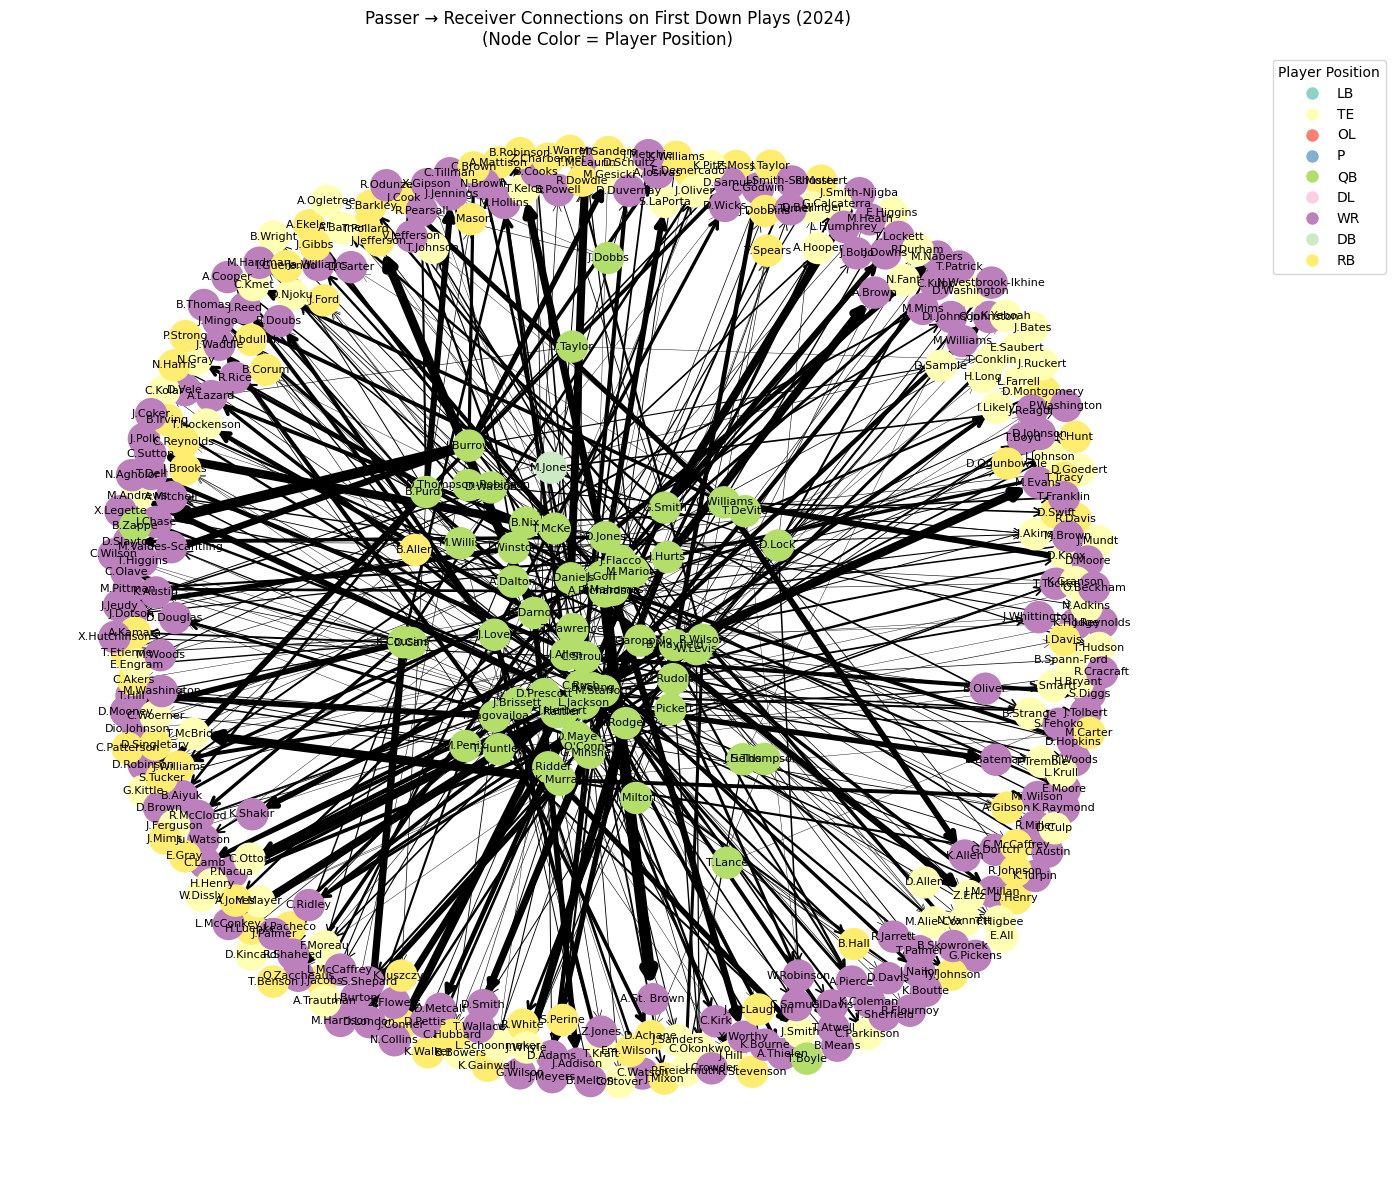

In [210]:
# Filter for plays resulting in a first down and where both passer and receiver are known
fd_pass_plays = df[
    (df['first_down'] == 1) &
    (df['passer_player_name'].notna()) &
    (df['receiver_player_name'].notna())
].copy()

fd_pass_plays["passer_position"] = fd_pass_plays['passer_player_id'].apply(lambda x: get_player_info(x, 'position'))
fd_pass_plays["receiver_position"] = fd_pass_plays['receiver_player_id'].apply(lambda x: get_player_info(x, 'position'))

# Create edge list: (passer, receiver)
edges = list(zip(fd_pass_plays['passer_player_name'], fd_pass_plays['receiver_player_name']))

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights (count how many times each passer → receiver pair occurs)
for edge in edges:
    if G.has_edge(*edge):
        G[edge[0]][edge[1]]['weight'] += 1
    else:
        G.add_edge(edge[0], edge[1], weight=1)

# Optionally, filter edges to show only those with weight > threshold (e.g., 2)
edges_to_draw = [(u, v) for u, v, w in G.edges(data='weight') if w > 2]

H = G.edge_subgraph(edges_to_draw).copy()

# Create a mapping of player names to positions
player_positions = {}

# Add passer positions
for _, row in fd_pass_plays[['passer_player_name', 'passer_position']].drop_duplicates().iterrows():
    player_positions[row['passer_player_name']] = row['passer_position']

# Add receiver positions
for _, row in fd_pass_plays[['receiver_player_name', 'receiver_position']].drop_duplicates().iterrows():
    player_positions[row['receiver_player_name']] = row['receiver_position']

# Get unique positions and create color mapping
unique_positions = list(set(player_positions.values()))
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_positions)))
position_color_map = dict(zip(unique_positions, colors))

# Map colors to nodes in the graph
node_colors = []
for node in H.nodes():
    if node in player_positions:
        node_colors.append(position_color_map[player_positions[node]])
    else:
        node_colors.append('gray')  # Default color for unknown positions

# Plotting
plt.figure(figsize=(14,12))

# Position nodes using spring layout (forces)
pos = nx.spring_layout(H, k=0.5, iterations=50)

# Draw nodes with position-based colors
nx.draw_networkx_nodes(H, pos, node_size=500, node_color=node_colors)

# Draw edges with widths proportional to weight (made thinner)
weights = [H[u][v]['weight'] for u,v in H.edges()]
nx.draw_networkx_edges(H, pos, width=[w*0.1 for w in weights], arrowstyle='->', arrowsize=15)

# Draw labels
nx.draw_networkx_labels(H, pos, font_size=8)

# Create legend for positions
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=position_color_map[pos], 
                             markersize=10, label=pos) 
                  for pos in unique_positions]
plt.legend(handles=legend_elements, title='Player Position', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Passer → Receiver Connections on First Down Plays (2024)\n(Node Color = Player Position)")
plt.axis('off')
plt.tight_layout()
plt.show()


While the visualization looks very chaotic, it shows that quarterbacks, largely clustered in the center pass to a variety of people and positions, who are visually represented by a ring around the quarterbacks.

While there are a lot of players involved we may actually want initially to consider the most relevant players involved in passing plays

In [217]:
# Filter for plays with a first down via pass, and valid passer + receiver names
first_down_passes = df[
    (df['first_down_pass'] == 1) & 
    df['passer_player_name'].notna() & 
    df['receiver_player_name'].notna() & 
    df['posteam'].notna()
].copy()

# Get full names for passer and receiver
first_down_passes['passer_player_name'] = first_down_passes['passer_player_id'].apply(lambda x: get_player_info(x, 'player_name'))
first_down_passes['receiver_player_name'] = first_down_passes['receiver_player_id'].apply(lambda x: get_player_info(x, 'player_name'))

# Group by passer, receiver, and offensive team (posteam), count occurrences
pair_counts = (
    first_down_passes
    .groupby(['passer_player_name', 'passer_player_id', 'receiver_player_name', 'receiver_player_id', 'posteam'])
    .size()
    .reset_index(name='First_Down_Count')
    .sort_values(by='First_Down_Count', ascending=False)
)

print(pair_counts.head(20))

    passer_player_name passer_player_id receiver_player_name  \
304         Jared Goff       00-0033106    Amon-Ra St. Brown   
344         Joe Burrow       00-0036442        Ja'Marr Chase   
569        Sam Darnold       00-0034869     Justin Jefferson   
451       Kyler Murray       00-0035228         Trey McBride   
67              Bo Nix       00-0039732     Courtland Sutton   
57      Baker Mayfield       00-0034855           Mike Evans   
421     Justin Herbert       00-0036355        Ladd McConkey   
118        C.J. Stroud       00-0039163         Nico Collins   
5        Aaron Rodgers       00-0023459       Garrett Wilson   
280        Jalen Hurts       00-0036389           A.J. Brown   
329     Jayden Daniels       00-0039910       Terry McLaurin   
253         Geno Smith       00-0030565   Jaxon Smith-Njigba   
544    Patrick Mahomes       00-0033873         Travis Kelce   
511   Matthew Stafford       00-0026498           Puka Nacua   
435       Kirk Cousins       00-0029604 

In [219]:
grouped = (
    first_down_passes
    .groupby(['posteam', 'passer_player_name', 'passer_player_id', 'receiver_player_name', 'receiver_player_id'])
    .size()
    .reset_index(name='First_Down_Count')
)

# Now, for example, get top 5 pairs per team
top_pairs_per_team = grouped.groupby('posteam').apply(
    lambda x: x.sort_values('First_Down_Count', ascending=False).head(5)
).reset_index(drop=True)

print(top_pairs_per_team)

    posteam passer_player_name passer_player_id receiver_player_name  \
0       ARI       Kyler Murray       00-0035228         Trey McBride   
1       ARI       Kyler Murray       00-0035228  Marvin Harrison Jr.   
2       ARI       Kyler Murray       00-0035228       Michael Wilson   
3       ARI       Kyler Murray       00-0035228         James Conner   
4       ARI       Kyler Murray       00-0035228          Greg Dortch   
..      ...                ...              ...                  ...   
155     WAS     Jayden Daniels       00-0039910       Terry McLaurin   
156     WAS     Jayden Daniels       00-0039910            Zach Ertz   
157     WAS     Jayden Daniels       00-0039910    Olamide Zaccheaus   
158     WAS     Jayden Daniels       00-0039910          Dyami Brown   
159     WAS     Jayden Daniels       00-0039910           Noah Brown   

    receiver_player_id  First_Down_Count  
0           00-0037744                63  
1           00-0039849                43  
2     

In [221]:
# For each team, get the top pair by First_Down_Count
top_pair_per_team = grouped.loc[grouped.groupby('posteam')['First_Down_Count'].idxmax()]

print(top_pair_per_team.head(20))

    posteam passer_player_name passer_player_id receiver_player_name  \
10      ARI       Kyler Murray       00-0035228         Trey McBride   
15      ATL       Kirk Cousins       00-0029604         Drake London   
41      BAL      Lamar Jackson       00-0034796          Zay Flowers   
48      BUF         Josh Allen       00-0034857        Khalil Shakir   
70      CAR        Bryce Young       00-0039150         Adam Thielen   
87      CHI     Caleb Williams       00-0039918             DJ Moore   
100     CIN         Joe Burrow       00-0036442        Ja'Marr Chase   
137     CLE     Jameis Winston       00-0031503          Jerry Jeudy   
143     DAL        Cooper Rush       00-0033662          CeeDee Lamb   
175     DEN             Bo Nix       00-0039732     Courtland Sutton   
196     DET         Jared Goff       00-0033106    Amon-Ra St. Brown   
220      GB        Jordan Love       00-0036264          Romeo Doubs   
236     HOU        C.J. Stroud       00-0039163         Nico Col

In [228]:
# Fuzzy match passer and receiver names to salary data
pair_salary_df = top_pair_per_team.copy()

# Merge salaries for passer
pair_salary_df = pair_salary_df.merge(
    player_salary_df[['player_name_x', 'base_salary', 'player_id']],
    left_on='passer_player_id',
    right_on='player_id',
    how='left'
).rename(columns={'base_salary': 'passer_salary'}).drop(columns=['player_name_x'])

# Merge salaries for receiver
pair_salary_df = pair_salary_df.merge(
    player_salary_df[['player_name_x', 'base_salary', 'player_id']],
    left_on='receiver_player_id',
    right_on='player_id',
    how='left'
).rename(columns={'base_salary': 'receiver_salary'}).drop(columns=['player_name_x'])

# Fill missing salaries with 0 (or you can drop those rows if you prefer)
pair_salary_df['passer_salary'] = pair_salary_df['passer_salary'].fillna(0)
pair_salary_df['receiver_salary'] = pair_salary_df['receiver_salary'].fillna(0)

# Calculate total salary and salary per first down
pair_salary_df['total_salary'] = pair_salary_df['passer_salary'] + pair_salary_df['receiver_salary']
pair_salary_df['salary_per_first_down'] = pair_salary_df['total_salary'] / pair_salary_df['First_Down_Count']

pair_salary_df = pair_salary_df.sort_values(by='salary_per_first_down', ascending=True)

# Format dollar amounts
pair_salary_df['passer_salary'] = pair_salary_df['passer_salary'].apply(lambda x: f"${x:,.2f}")
pair_salary_df['receiver_salary'] = pair_salary_df['receiver_salary'].apply(lambda x: f"${x:,.2f}")
pair_salary_df['total_salary'] = pair_salary_df['total_salary'].apply(lambda x: f"${x:,.2f}")
pair_salary_df['salary_per_first_down'] = pair_salary_df['salary_per_first_down'].apply(lambda x: f"${x:,.2f}")

# Show relevant columns
display_df = pair_salary_df[['posteam', 'passer_player_name', 'receiver_player_name', 'First_Down_Count', 'passer_salary', 'receiver_salary', 'total_salary', 'salary_per_first_down']]
print(display_df.head(20).to_string(index=False))

posteam passer_player_name receiver_player_name  First_Down_Count passer_salary receiver_salary  total_salary salary_per_first_down
    DEN             Bo Nix     Courtland Sutton                61   $795,000.00   $1,125,000.00 $1,920,000.00            $31,475.41
    PHI        Jalen Hurts           A.J. Brown                58 $1,125,000.00   $1,125,000.00 $2,250,000.00            $38,793.10
     TB     Baker Mayfield           Mike Evans                60 $1,125,000.00   $1,210,000.00 $2,335,000.00            $38,916.67
    HOU        C.J. Stroud         Nico Collins                58   $915,000.00   $1,616,000.00 $2,531,000.00            $43,637.93
    DET         Jared Goff    Amon-Ra St. Brown                81 $2,611,832.00   $1,366,000.00 $3,977,832.00            $49,109.04
     SF        Brock Purdy        George Kittle                44   $985,000.00   $1,210,000.00 $2,195,000.00            $49,886.36
    BUF         Josh Allen        Khalil Shakir                42 $1,125,000

In [229]:
df_plot = pair_salary_df.copy()
df_plot['salary_per_first_down_num'] = df_plot['salary_per_first_down'].replace('[\$,]', '', regex=True).astype(float)
df_plot['total_salary'] = df_plot['total_salary'].replace('[\$,]', '', regex=True).astype(float)

# Optional: a text column to use in tooltips and labels
df_plot['label'] = df_plot.apply(
    lambda row: f"{row['posteam']}: {row['passer_player_name']} & {row['receiver_player_name']}", axis=1
)

# Base chart
base = alt.Chart(df_plot).encode(
    x=alt.X('First_Down_Count:Q', title='First Down Count (Volume)'),
    y=alt.Y('total_salary:Q', title='Total Salary ($)', 
            axis=alt.Axis(format='$,.0f')),
    size=alt.Size('First_Down_Count:Q', scale=alt.Scale(type='pow', exponent=2, range=[30, 400])),
    color=alt.Color('salary_per_first_down_num:Q', scale=alt.Scale(scheme='viridis'),
                    title='Salary per First Down ($)'),
    tooltip=[
        alt.Tooltip('posteam:N', title='Team'),
        alt.Tooltip('passer_player_name:N', title='Quarterback'),
        alt.Tooltip('receiver_player_name:N', title='Receiver'),
        alt.Tooltip('First_Down_Count:Q', title='First Down Count'),
        alt.Tooltip('total_salary:Q', format='$,.0f', title='Total Salary'),
        alt.Tooltip('salary_per_first_down_num:Q', format='$,.0f', title='Salary per First Down')
    ]
)

# Scatter plot
points = base.mark_circle(opacity=0.7, stroke='white', strokeWidth=0.5)

# Combine
chart = (points).properties(
    width=700,
    height=500,
    title='Top Passer-Receiver Pairs by Total Salary vs. First Down Count\n(Size = Volume, Color = Cost per First Down)'
)

chart.show()

alt.Chart(...)